# Run Experiments on Fjord

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from collections import defaultdict
from anytree.importer import JsonImporter
from utils.custom_dataset import CustomDataset
from ultralytics import RTDETR
import contextlib
import io

# extract test data
df = pd.read_parquet('datasets/segmented-objects-dataset.parquet')

# Assuming df is your DataFrame with all data
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Local version of get labels
def get_hierarchical_labels(species_index, species_names, genus_names, class_names, binary_names, root):
    if species_index == -1:
        return -1, -1, -1  # Handle cases where species_index is invalid

    species_name = species_names[species_index]
    node = next((n for n in root.descendants if n.name == species_name), None)

    if node is None:
        return -1, -1, -1  # Species not found in the tree

    genus_index, class_index, binary_index = -1, -1, -1
    current_node = node
    while current_node.parent is not None:
        current_node = current_node.parent
        if current_node.rank == 'genus':
            genus_index = genus_names.index(current_node.name) if current_node.name in genus_names else -1
        elif current_node.rank == 'class':
            class_index = class_names.index(current_node.name) if current_node.name in class_names else -1
        elif current_node.rank == 'binary':
            binary_index = binary_names.index(current_node.name) if current_node.name in binary_names else -1

    return genus_index, class_index, binary_index

## Load Model and run experiments

In [2]:
def run_experiment(data_path, classes_file, model_path, ablation, root):
    df = pd.read_parquet(data_path)
    _, test_df = train_test_split(df, test_size=0.3, random_state=42)

    object_names = [line.strip() for line in open(classes_file, 'r')]
    subcategory_names, category_names, binary_names = [], [], []
    for node in root.descendants:
        if node.rank == 'genus':
            subcategory_names.append(node.name)
        elif node.rank == 'class':
            category_names.append(node.name)
        elif node.rank == 'binary':
            binary_names.append(node.name)

    rank_counts = defaultdict(int)
    for node in root.descendants:
        rank_counts[node.rank] += 1
    num_classes_hierarchy = [rank_counts['binary'], rank_counts['class'], rank_counts['genus'], rank_counts['species']]

    if ablation == 'RT-DETR':
        model = RTDETR(model_path)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
    else:
        from models.hierarchical_cnn import HierarchicalCNN
        num_additional_features = 3  # e.g., conf, iou, pred_species
        if ablation == 'baseline':
            model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
        elif ablation == 'Yolov8':
            model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
        elif ablation == 'remove_features':
            from models.ablations.remove_features.hierarchical_cnn import HierarchicalCNN
            model = HierarchicalCNN(num_classes_hierarchy)
        elif ablation == 'attention_removed':
            from models.ablations.attention_removed.hierarchical_cnn import HierarchicalCNN
            model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
        elif ablation == 'decreased_branch_complexity':
            from models.ablations.decreased_branch_complexity.hierarchical_cnn import HierarchicalCNN
            model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
        elif ablation == 'increased_features_complexity':
            from models.ablations.increased_features_complexity.hierarchical_cnn import HierarchicalCNN
            model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
        else:
            raise ValueError(f"Unsupported ablation study: {ablation}")

        model.load_state_dict(torch.load(model_path))
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        model.eval()

    test_dataset = CustomDataset(test_df, object_names, subcategory_names, category_names, binary_names, root)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    true_labels = {level: [] for level in ['binary', 'class', 'genus', 'species']}
    predictions = {level: [] for level in ['binary', 'class', 'genus', 'species']}

    with torch.no_grad():
        for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
            if ablation == 'RT-DETR':
                with contextlib.redirect_stdout(io.StringIO()):  # Redirect stdout to suppress prints
                    results = model(images)
                for result in results:
                    boxes = result.boxes
                    if boxes is not None and len(boxes) > 0:
                        for box in boxes:
                            species_pred = int(box.cls)
                            genus_idx, class_idx, binary_idx = get_hierarchical_labels(species_pred, object_names, subcategory_names, category_names, binary_names, root)
                            predictions['species'].append(species_pred)
                            predictions['genus'].append(genus_idx)
                            predictions['class'].append(class_idx)
                            predictions['binary'].append(binary_idx)
                    else:
                        # No detections: append -1 to indicate no prediction
                        predictions['species'].append(-1)
                        predictions['genus'].append(-1)
                        predictions['class'].append(-1)
                        predictions['binary'].append(-1)
            else:
                images, conf, iou, pred_species = [x.to(device) for x in [images, conf, iou, pred_species]]
                outputs = model(images, conf, iou, pred_species) if ablation != 'remove_features' else model(images)
                for i, output in enumerate(outputs):
                    _, predicted = torch.max(output, 1)
                    level = ['binary', 'class', 'genus', 'species'][i]
                    predictions[level].extend(predicted.cpu().numpy())

            true_labels['binary'].extend(binary_index.cpu().numpy())
            true_labels['class'].extend(class_index.cpu().numpy())
            true_labels['genus'].extend(genus_index.cpu().numpy())
            true_labels['species'].extend(species_index.cpu().numpy())

    # Remove cases where no predictions were made
    for level in ['binary', 'class', 'genus', 'species']:
        true_labels[level] = [label for label, pred in zip(true_labels[level], predictions[level]) if pred != -1]
        predictions[level] = [pred for pred in predictions[level] if pred != -1]

    f1_scores = {level: f1_score(true_labels[level], predictions[level], average='macro') for level in ['binary', 'class', 'genus', 'species']}
    return f1_scores

# Populate Taxonomy
importer = JsonImporter()
with open('datasets/ontology.json', 'r') as f:
    root = importer.read(f)

# Paths and setup
data_path = 'datasets/segmented-objects-dataset.parquet'
classes_file = 'datasets/EMVSD/EMVSD/classes.txt'
ablations = ['RT-DETR']
alpha_values = [0]

# Run experiments and collect results
results = []
for ablation in ablations:
    for alpha in alpha_values:
        if ablation in ['Yolov8', 'baseline']:
            model_path = f'datasets/hierarchical-model-weights/weights/best_model_alpha_{alpha:.2f}.pth'
        elif ablation == 'RT-DETR':
            model_path = 'runs/detect/rtdetr-l-seg-train/weights/best.pt'
        else:
            model_path = f'datasets/hierarchical-model-weights/ablations/{ablation}/weights/best_model_alpha_{alpha:.2f}.pth'
        f1_scores = run_experiment(data_path, classes_file, model_path, ablation, root)
        results.append({'Ablation': ablation, 'Alpha': alpha, **f1_scores})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df.round(4)


0: 128x128 (no detections), 10.8ms
1: 128x128 (no detections), 10.8ms
2: 128x128 (no detections), 10.8ms
3: 128x128 (no detections), 10.8ms
4: 128x128 (no detections), 10.8ms
5: 128x128 (no detections), 10.8ms
6: 128x128 (no detections), 10.8ms
7: 128x128 (no detections), 10.8ms
8: 128x128 (no detections), 10.8ms
9: 128x128 (no detections), 10.8ms
10: 128x128 (no detections), 10.8ms
11: 128x128 (no detections), 10.8ms
12: 128x128 (no detections), 10.8ms
13: 128x128 (no detections), 10.8ms
14: 128x128 (no detections), 10.8ms
15: 128x128 (no detections), 10.8ms
16: 128x128 (no detections), 10.8ms
17: 128x128 (no detections), 10.8ms
18: 128x128 (no detections), 10.8ms
19: 128x128 (no detections), 10.8ms
20: 128x128 (no detections), 10.8ms
21: 128x128 (no detections), 10.8ms
22: 128x128 (no detections), 10.8ms
23: 128x128 (no detections), 10.8ms
24: 128x128 (no detections), 10.8ms
25: 128x128 (no detections), 10.8ms
26: 128x128 (no detections), 10.8ms
27: 128x128 (no detections), 10.8ms
2

,Ablation,Alpha,binary,class,genus,species
0,RT-DETR,0,0.2635,0.1064,0.0744,0.0744


In [3]:
results_df

,Ablation,Alpha,binary,class,genus,species
0,RT-DETR,0,0.263498,0.106449,0.074421,0.074421



0: 640x640 1 pipe, 72.8ms
Speed: 4.2ms preprocess, 72.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


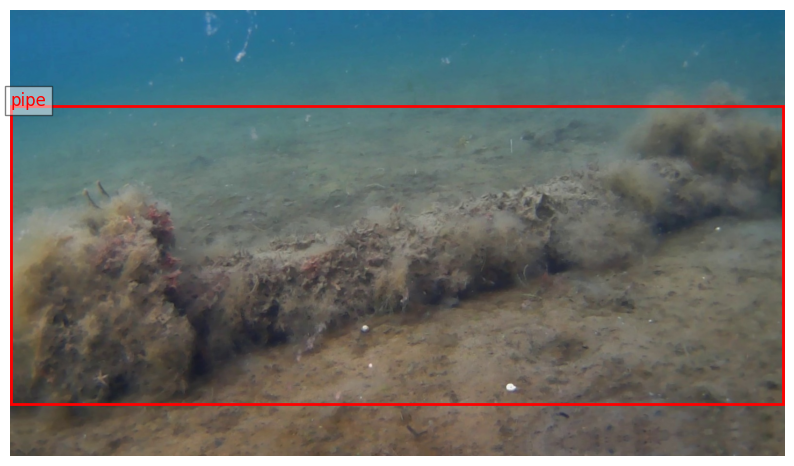

In [4]:
import torch
from ultralytics import RTDETR
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the RT-DETR model
model_path = 'runs/detect/rtdetr-l-seg-train/weights/best.pt'
model = RTDETR(model_path)

# Path to the test image
image_path = 'datasets/EMVSD/EMVSD/images/test/frame000011.jpg'

# Load the image
image = Image.open(image_path).convert('RGB')

# Perform prediction
results = model(image)

# Display the image with predictions
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')

# Extract and draw boxes and labels
for box in results[0].boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', linewidth=2))
    plt.text(x1, y1, model.names[int(box.cls)], color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [5]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'asterias rubens', 1: 'asteroidea', 2: 'fucus vesiculosus', 3: 'henricia', 4: 'mytilus edulis', 5: 'myxine glurinosa', 6: 'pipe', 7: 'rock', 8: 'saccharina latissima', 9: 'tree', 10: 'ulva intestinalis', 11: 'urospora', 12: 'zostera marina'}
 obb: None
 orig_img: array([[[148, 109,  34],
         [148, 109,  34],
         [148, 109,  34],
         ...,
         [134,  98,  28],
         [134,  98,  28],
         [134,  98,  28]],
 
        [[148, 109,  34],
         [148, 109,  34],
         [148, 109,  34],
         ...,
         [133,  97,  27],
         [133,  97,  27],
         [133,  97,  27]],
 
        [[148, 109,  34],
         [148, 109,  34],
         [148, 109,  34],
         ...,
         [133,  96,  28],
         [133,  96,  28],
         [131,  96,  28]],
 
        ...,
 
        [[ 63,  76,  84],
         [ 63,  76,  84],